#### Deploy cancer vs non-cancer classifier 

In [17]:
import numpy as np
import cv2
import time
from glob import glob
import os
import matplotlib.pylab as plt
from sklearn.externals import joblib
from skimage import measure
from skimage.transform import resize
import ntpath
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#p = sns.color_palette()
from skimage.draw import circle
#import re
#import traceback
import dicom
import h5py
import random

# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print '%s: %s' %(var,module.__version__)
    
# package version    
get_version('numpy','matplotlib','cv2','sklearn','skimage','scipy','pandas')

numpy: 1.11.2
matplotlib: 1.5.1
cv2: 3.1.0
sklearn: 0.18.1
skimage: 0.12.3
scipy: 0.18.1
pandas: 0.19.2


## settings

In [4]:

# data path
root_data='.'
path2dsb=root_data+'/output/data/dsb.hdf5'
path2luna=root_data+'/output/data/luna/'
path2csv=root_data+'/output/data/stage1_labels.csv'
path2logs='./output/logs/'


# resize
H,W=512,512

#K.set_image_dim_ordering('th')  # Theano dimension ordering in this code

# original data dimension
img_rows = 512
img_cols = 512

# batch size
bs=16

# trained data dimesnsion
h,w=512,512

# exeriment name to record weights and scores
experiment='ClassifyLUNAvsDSB_aug'+'_hw_'+str(h)+'by'+str(w)
print ('experiment:', experiment)

# checkpoint
weightfolder='./output/weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print ('weights folder created')



('experiment:', 'ClassifyLUNAvsDSB_aug_hw_512by512')


## utils

In [6]:


# functions
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Dropout
from keras.optimizers import Adam
#from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint ,LearningRateScheduler
#from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Activation,Reshape,Permute,Flatten,Dense
#from keras.layers.advanced_activations import ELU
#from keras.models import Model
from keras import backend as K
#from keras.optimizers import Adam#, SGD
from keras.models import Sequential
#from funcs.image import ImageDataGenerator


# model
def model(params):

    h=params['img_rows']
    w=params['img_cols']
    z=params['img_depth']
    lr=params['learning_rate']
    weights_path=params['weights_path']
    loss=params['loss']
    C=params['nb_filters']
    nb_output=params['nb_output']
    
    model = Sequential()
    model.add(Convolution2D(C, 3, 3, activation='relu',subsample=(2,2),border_mode='same', input_shape=(z, h, w)))

    N=6
    for k in range(1,N):
        C1=np.min([2**k*C,512])
        model.add(Convolution2D(C1, 3, 3, activation='relu', subsample=(1,1), border_mode='same'))              
        model.add(Convolution2D(C1, 3, 3, subsample=(1,1), activation='relu', border_mode='same'))              
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Convolution2D(C1, 3, 3, activation='relu', border_mode='same'))              
    model.add(Convolution2D(C1, 3, 3, activation='relu', border_mode='same'))              
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.1))

    model.add(Dense(nb_output, activation='sigmoid'))
    
    #load previous weights
    if weights_path:
        model.load_weights(weights_path)

    model.compile(loss=loss, optimizer=Adam(lr))

    return model
    
# preprocess
def preprocess(X,param_prep):
    # X,Y: n,c,h,w
    N,C,H,W=X.shape
    
    # get params
    h=param_prep['h']
    w=param_prep['w']    
    crop=param_prep['crop']
    norm_type=param_prep['norm_type'] # normalization 
    output=param_prep['output'] # output
    
    
    # center crop h*w
    if crop is 'center':
        hc=(H-h)/2
        wc=(W-w)/2
        X=X[:,:,hc:H-hc,wc:W-wc]
    elif crop is 'random':
        hc=(H-h)/2
        wc=(W-w)/2
        hcr=np.random.randint(hc)
        wcr=np.random.randint(wc)
        X=X[:,:,hcr:H-hcr,wcr:W-wcr]
        
    # check if need to downsample
    # resize if needed
    if h<H:
        X_r=np.zeros([N,C,h,w],dtype=X.dtype)
        for k1 in range(N):
            for k2 in range(C):
                X_r[k1,k2,:] = cv2.resize(X[k1,k2], (w, h), interpolation=cv2.INTER_CUBIC)
    else:
        X_r=X

    # normalization
    X_r=np.array(X_r,dtype='float32')
    if norm_type is 'global':
        X_r-=np.mean(X_r)
        X_r/=np.std(X_r)
    elif norm_type is 'local':
        for k in range(X_r.shape[0]):
            mean = np.mean(X_r[k,0])  # mean       
            sigma = np.std(X_r[k,0])  # std
            if sigma<1e-5:
                sigma=1
            X_r[k] = X_r[k]-mean
            X_r[k] = X_r[k]/ sigma
    elif norm_type is 'scale':
        X_r-=np.min(X_r)
        X_r/=np.max(X_r)
    elif norm_type is 'minmax_bound':        
        # normalization
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0
        
        X_r = (X_r - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        X_r[X_r>1] = 1.
        X_r[X_r<0] = 0.

    return X_r


####### normalization
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))



def image_with_mask(img, mask,color=(0,255,0)):
    maximg=np.max(img)    
    img=np.asarray(img,dtype='float32')
    img=np.asarray((img/maximg)*255,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
	img_color = grays_to_RGB(img)
    else:
	img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = color[1]
    img_color[mask_edges, 2] = color[2]
    img_color=img_color#/float(np.max(img))
    return img_color

def disp_img_2masks(img,mask1,mask2,r=1,c=1,d=0,indices=None):
    if mask1 is None:
        mask1=np.zeros(img.shape,dtype='uint8')
    if mask2 is None:
        mask2=np.zeros(img.shape,dtype='uint8')
        
    N=r*c    
    if d==2:
        # convert to N*C*H*W
        img=np.transpose(img,(2,0,1))
        img=np.expand_dims(img,axis=1)
        
        mask1=np.transpose(mask1,(2,0,1))
        mask1=np.expand_dims(mask1,axis=1)

        mask2=np.transpose(mask2,(2,0,1))
        mask2=np.expand_dims(mask2,axis=1)
        
    if indices is None:    
        # random indices   
        n1=np.random.randint(img.shape[0],size=N)
    else:
        n1=indices
    
    I1=img[n1,0]
    #M1=mask1[n1,0]
    M1=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask1.shape[1]):
        M1=np.logical_or(M1,mask1[n1,c1,:])    
    #M2=mask2[n1,0]
    M2=np.zeros(I1.shape,dtype='uint8')
    for c1 in range(mask2.shape[1]):
        M2=np.logical_or(M2,mask2[n1,c1,:])    
    
    C1=(0,255,9)
    C2=(255,0,0)
    for k in range(N):    
        imgmask=image_with_mask(I1[k],M1[k],C1)
        imgmask=image_with_mask(imgmask,M2[k],C2)
        plt.subplot(r,c,k+1)
        plt.imshow(imgmask)
        plt.title(n1[k])
    plt.show()            
    return n1        




def array_stats(X):
    X=np.asarray(X)
    
    # get var name
    #stack = traceback.extract_stack()
    #filename, lineno, function_name, code = stack[-2]
    #vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    
    #print (vars_name,X.shape, X.dtype)
    print ('array shape',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
    
    print '-'*50

    
# extract three consecutive images from BS subject
def extract_dsb(trn_nc,bs,df_train):
    # pick bs random subjects
    rnd_nc_inds=random.sample(trn_nc,bs)    
    
    # read h5 file
    f2=h5py.File(path2dsb,'r')
    
    # initialize    
    X=np.zeros((bs,3,H,W),'int16')
    y=np.zeros(bs,dtype='uint8')
    for k,ind in enumerate(rnd_nc_inds):
        p_id=df_train.id[ind]
        #print p_id
    
        X0=f2[p_id]
    
        # pick three concecutive slices
        n1=np.random.randint(len(X0)-3)
        #print n1
        X0=X0[n1:n1+3]
        #array_stats(X0) 
        X[k,:]=X0
    
    f2.close()    
    return X,y


def logloss(act, pred):
    epsilon = 1e-5
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll
    

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


### load test data from LUNA 2016 data set

In [10]:
### load luna data, all cancer
f1=h5py.File(path2luna+'luna.hdf5','r')
X_train=f1['X_train']
y_train=f1['y_train']
X_test=f1['X_test']
y_test=f1['y_test']

array_stats(X_train)
array_stats(y_train)

array_stats(X_test)
array_stats(y_test)


('array shape', (1067, 3, 512, 512), dtype('int16'))
min: -32768, max: 32711, avg: -7.99e+02, std:8.86e+02
--------------------------------------------------
('array shape', (1067,), dtype('uint8'))
min: 1, max: 1, avg: 1.0, std:0.0
--------------------------------------------------
('array shape', (119, 3, 512, 512), dtype('int16'))
min: -3024, max: 7383, avg: -8.07e+02, std:8.92e+02
--------------------------------------------------
('array shape', (119,), dtype('uint8'))
min: 1, max: 1, avg: 1.0, std:0.0
--------------------------------------------------


## load DSB

In [11]:
########## load DSB data, only non-cancer
df_train = pd.read_csv(path2csv)
print('Number of training patients: {}'.format(len(df_train)))
print('Cancer rate: {:.4}%'.format(df_train.cancer.mean()*100))
df_train.head()

# extract non cancers
non_cancer=df_train[df_train.cancer==0].index
cancer=df_train[df_train.cancer==1].index
print 'total non cancer:%s, total cancer:%s' %(len(non_cancer),len(cancer))

# total non cancers
nb_noncancer=len(non_cancer)
y_dsb=np.zeros(nb_noncancer,dtype='uint8')

# train val split
path2trainvalindx=weightfolder+'/dsb_train_val_index'
if not os.path.exists(path2trainvalindx+'.npz'):
    trn_nc, val_nc, trn_y, val_y = cross_validation.train_test_split(non_cancer,y_dsb, random_state=420, stratify=y_dsb,test_size=0.1)                                                                   
    np.savez(path2trainvalindx,trn_nc=trn_nc,trn_y=trn_y,val_nc=val_nc,val_y=val_y)
else:
    out1=np.load(path2trainvalindx+'.npz')
    trn_nc=out1['trn_nc']
    trn_y=out1['trn_y']    
    val_nc=out1['val_nc']    
    val_y=out1['val_y']    
    print 'previous indices loaded!'


Number of training patients: 1397
Cancer rate: 25.91%
total non cancer:1035, total cancer:362
previous indices loaded!


### checking Hisograms

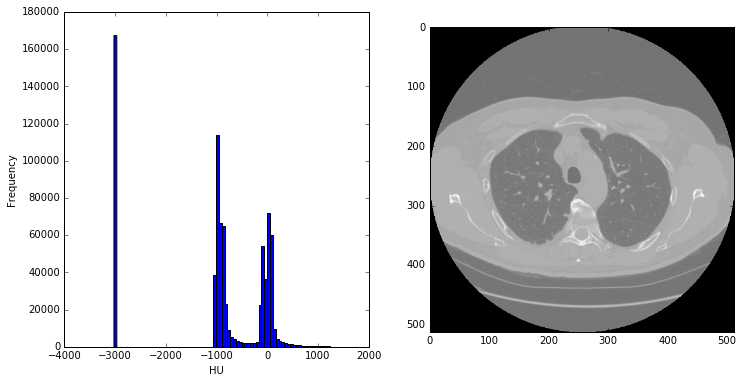

In [12]:
sn=70

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(X_test[sn].flatten(), bins=80)
plt.xlabel("HU")
plt.ylabel("Frequency")

# Show some slice in the middle
plt.subplot(1,2,2)
plt.imshow(X_test[sn,0], cmap='gray')
plt.show()

## AI model

In [14]:
# training params
params_train={
    'img_rows': h,
    'img_cols': w,
    'img_depth':3,
    'weights_path': None,        
    'learning_rate': 3e-4,
    'optimizer': 'Adam',
    'loss': 'binary_crossentropy',
    #'loss': 'mean_squared_error',
    #'loss': 'dice',
    'nbepoch': 1000,
    'nb_output': 1,
    'nb_filters': 8,    
    'max_patience': 30    
        }

model = model(params_train)
model.summary()

# path to weights
path2weights=weightfolder+"/weights.hdf5"

if os.path.exists(path2weights):
    model.load_weights(path2weights)
    print 'weights loaded!'
else:
    raise IOError


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 8, 256, 256)   224         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 256, 256)  1168        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 16, 256, 256)  2320        convolution2d_2[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 128, 128)  0           convolution2d_3[0][0]            
___________________________________________________________________________________________

## evaluate AI model on test data from LUNA 2016

In [15]:
# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : 'minmax_bound',
    'output' : 'coords',
}

print 'wait ...'
score_test=model.evaluate(preprocess(X_test,param_prep),y_test,verbose=0)
score_train=model.evaluate(preprocess(X_train,param_prep),y_train,verbose=0)
print ('score_train: %s, score_test: %s' %(score_train,score_test))

score_train: 0.0221798781588, score_test: 0.0339332536771
------------------------------
Predicting masks on test data...
------------------------------


## Deploy on mix of LUNA and DSB

wait ...
loss test: 0.15702201225
accuracy: 1.00


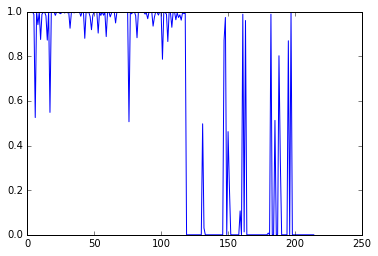

In [19]:
tt='test'

print 'wait ...'

# pre-processing 
param_prep={
    'h': h,
    'w': w,
    'crop'    : None,
    'norm_type' : 'minmax_bound',
    'output' : 'mask',
}

if tt is 'train':
    n1=np.random.randint(len(X_train),size=100)
    X=preprocess(X_train[n1],param_prep)
    y=y_train[n1]
else:
    X_dsb,y_dsb=extract_dsb(val_nc,6*bs,df_train)        
    X=preprocess(np.append(X_test,X_dsb,axis=0),param_prep)
    y=np.append(y_test,y_dsb)

# prediction
logloss_test=model.evaluate(X,y,verbose=0)    
y_pred=model.predict(X)
delta=np.abs((y-y_pred[:,0]>0.5)*1.)
plt.plot(y_pred[:,0])

print 'loss test: %s' %logloss_test
print 'accuracy: %.2f' %(1-np.sum(delta)/len(y))


## Deploy on non-Cancer Data from DSB

wait ...
processing: 1055 c19197af81f94110ddc23317e182f37d
[6 7 8]
(77, 3, 512, 512)


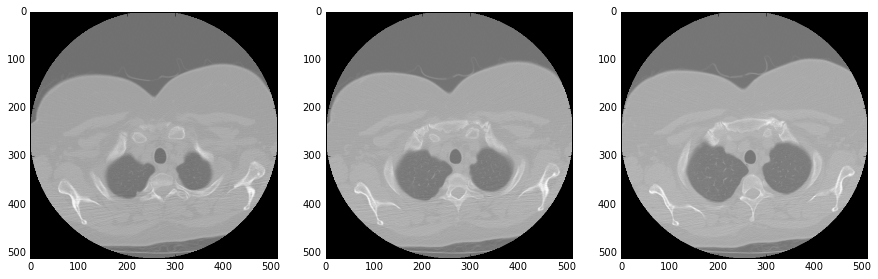

processing: 771 8c5288b86ffcd597f10d639e9948411d
[27 23 25]
(52, 3, 512, 512)


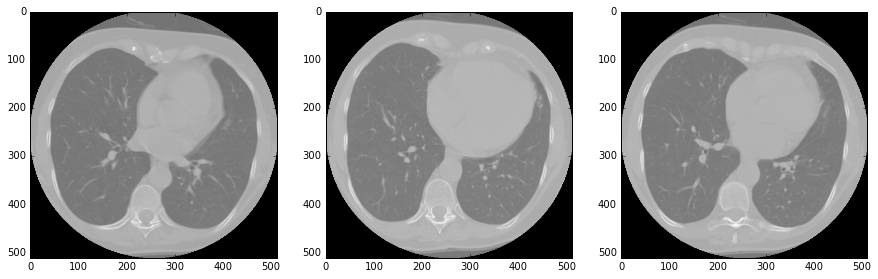

processing: 300 3557455d81f42ee54ad0544f36933e9a
[23  0 29]
(54, 3, 512, 512)


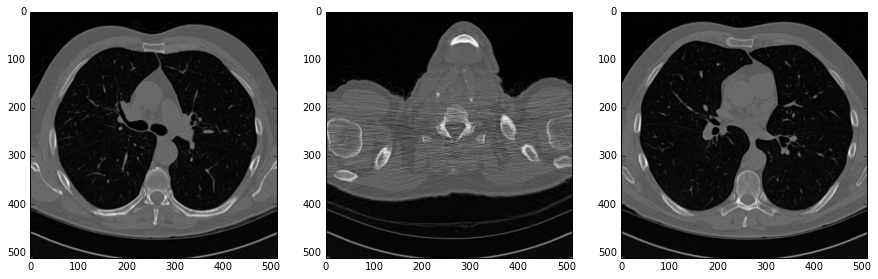

processing: 1213 de9f65a7a70b73ce2ffef1e4a2613eee
[46 41 42]
(47, 3, 512, 512)


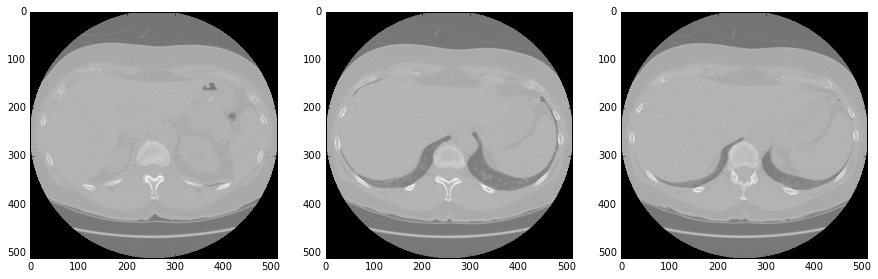

processing: 81 0fe9dd36f4dece7f4ec017433c4d4a50
[ 6 22 23]
(40, 3, 512, 512)


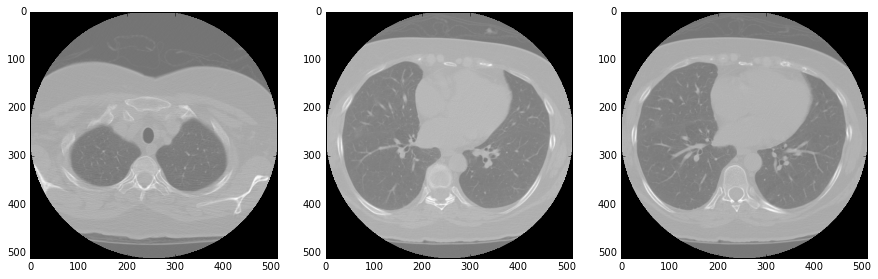

processing: 998 b8ad1b45ae4ba6c97951ed30b8640f6b
[51 52 50]
(64, 3, 512, 512)


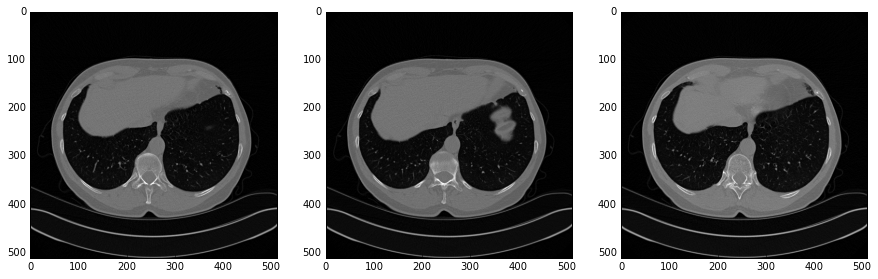

processing: 1163 d5c43054ba0f66d5017a8ddfde8c8c34
[26 11 27]
(52, 3, 512, 512)


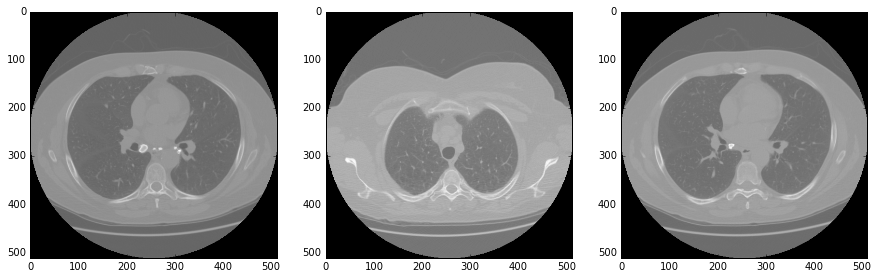

processing: 802 92286959d1899e9b480d29c545cb1e0f
[32 40 37]
(41, 3, 512, 512)


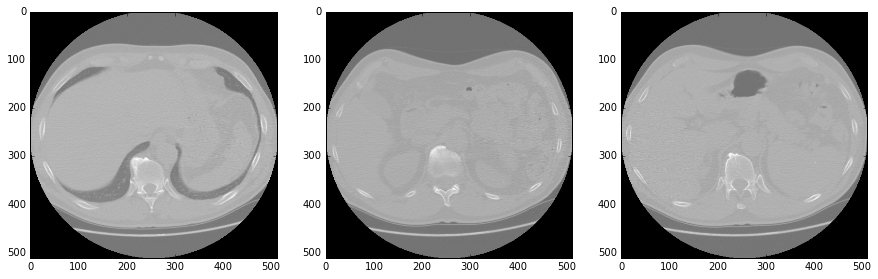

processing: 1040 bfb3e2d11c149036bbe12566ef6b933c
[16 21 11]
(61, 3, 512, 512)


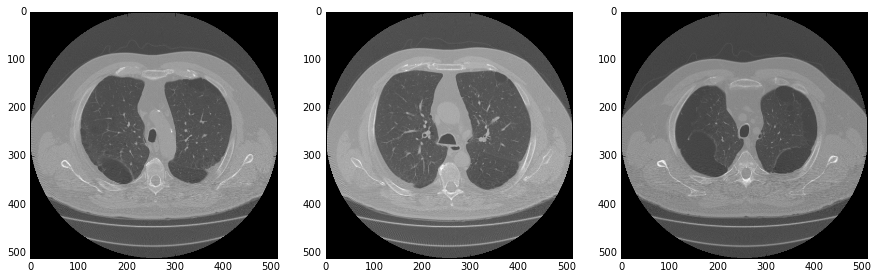

processing: 1048 c0712bc73239d89cddd71a93865e2946
[18  8 10]
(44, 3, 512, 512)


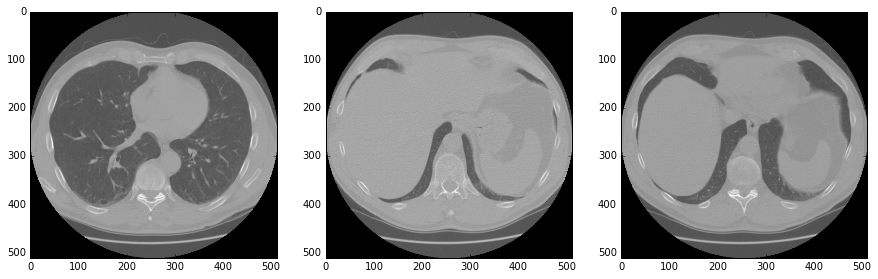

processing: 1209 de04fbf5e6c2389f0d039398bdcda971
[38 48 45]
(51, 3, 512, 512)


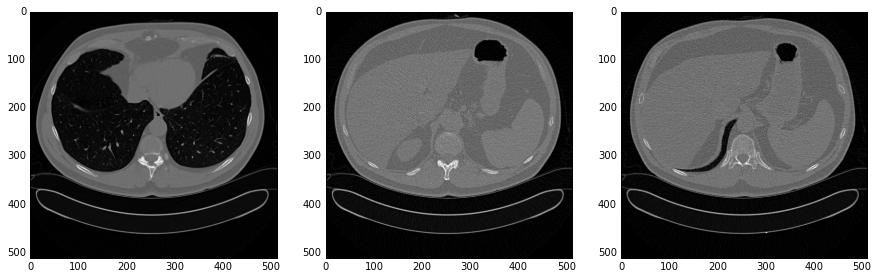

processing: 1128 ced4f41abff9290b0638b0a25cd5a26d
[29 24 30]
(68, 3, 512, 512)


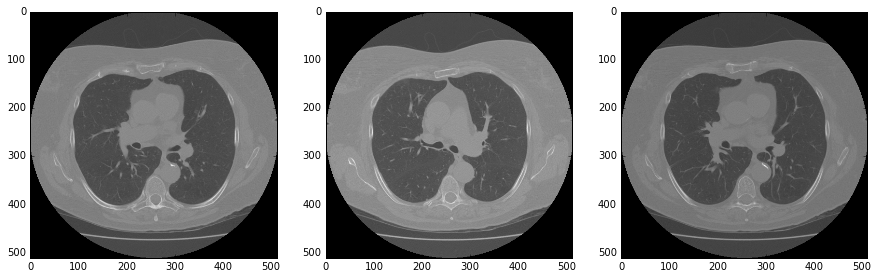

processing: 1271 e858263b89f0bb57597bcff325eaeecf
[43  3 54]
(55, 3, 512, 512)


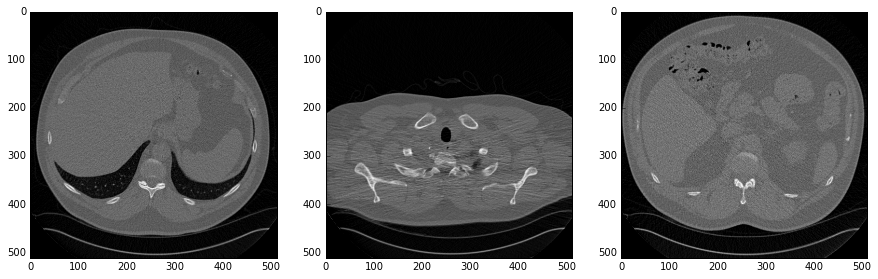

processing: 1084 c645eb8b7b7225457e61cf511a8e46e5
[30 33 31]
(56, 3, 512, 512)


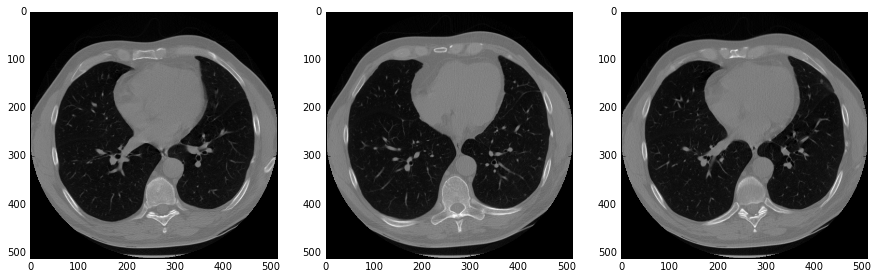

processing: 592 6c56e9802fb6346db58bd5daf160f9be
[45 44 30]
(62, 3, 512, 512)


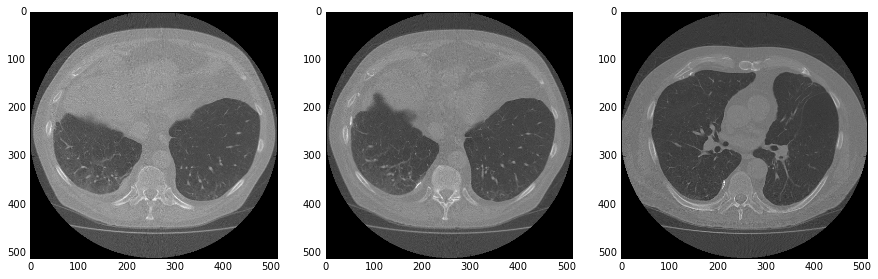

processing: 12 01e349d34c06410e1da273add27be25c
[45 27 41]
(52, 3, 512, 512)


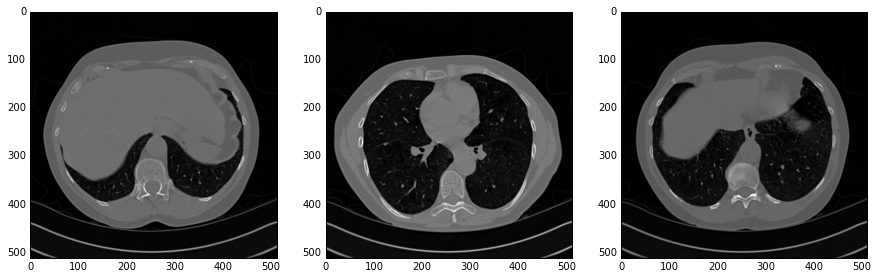

processing: 819 9626af3a0a37c4fa5187447f01aa69da
[42 41 30]
(54, 3, 512, 512)


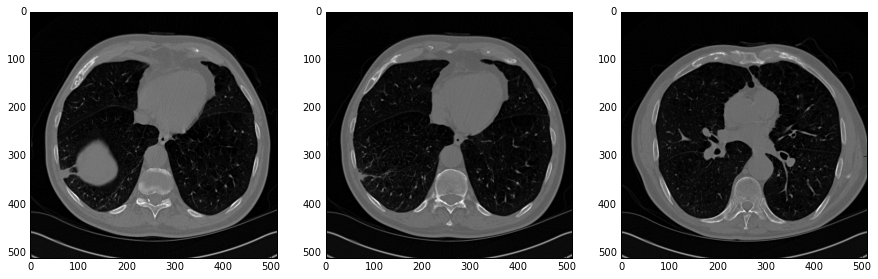

processing: 572 67e87fa621f2e3e838b1b17a898d5b41
[2 1 3]
(38, 3, 512, 512)


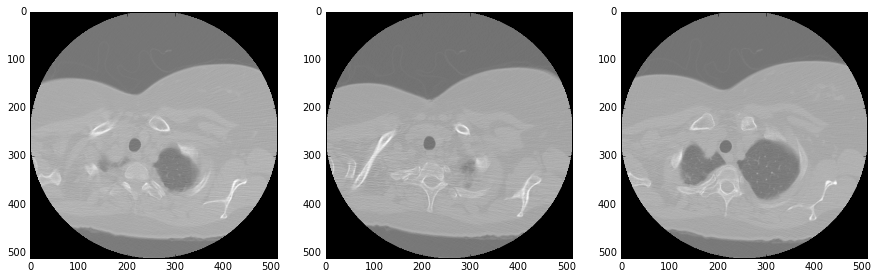

processing: 619 722429bc9cb25d6f4b7a820c14bf2ab1
[34 32 37]
(38, 3, 512, 512)


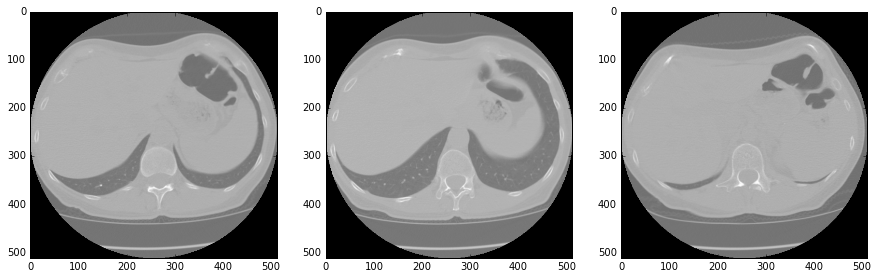

processing: 742 87b81bd007c5b23cd0c0aeca722fe52f
[54 52 51]
(57, 3, 512, 512)


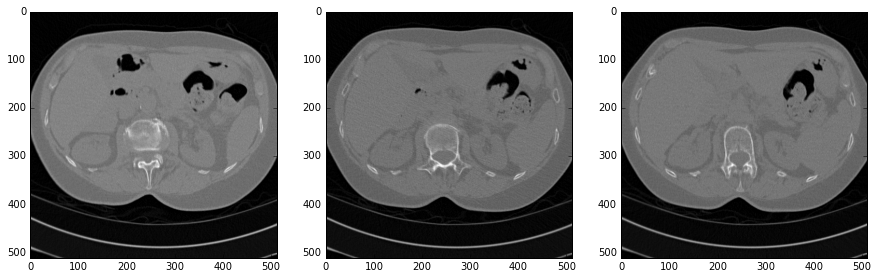

In [62]:
print 'wait ...'

# load data
y_pred=[]
for p in val_nc[:20]:
    p_id=df_train.id[p]
    print 'processing: %s %s' %(p,p_id)
    f3=h5py.File(path2dsb,'r')
    X0=f3[p_id]

    X3=[]
    step=3
    for k in range(0,X0.shape[0]-3,step):
        tmp=X0[k:k+3]
        tmp=tmp[np.newaxis,:]
        X3.append(tmp)
    X3=np.vstack(X3)        
    y_p=model.predict(preprocess(X3,param_prep))
    y_pred.append(y_p[:,0])   
    
    # top n values    
    n=3
    yk=np.array(y_p[:,0])
    idx = (-yk).argsort()[:n]
    print idx
    print X3.shape
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(X3[idx[0],0],cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(X3[idx[1],0],cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(X3[idx[2],0],cmap='gray')
    plt.show()


# get avg max, avg of top max
yp_avg=[]
yp_max=[]
yp_avgtop=[]
for k in range(len(y_pred)):
    yp_avg.append(np.mean(y_pred[k]))
    yp_max.append(np.max(y_pred[k]))
    n=3
    yk=np.array(y_pred[k])
    idx = (-yk).argsort()[:n]
    #print idx
    yp_avgtop.append(np.mean(yk[idx]))


yp_avg=np.array(yp_avg)
yp_max=np.array(yp_max)


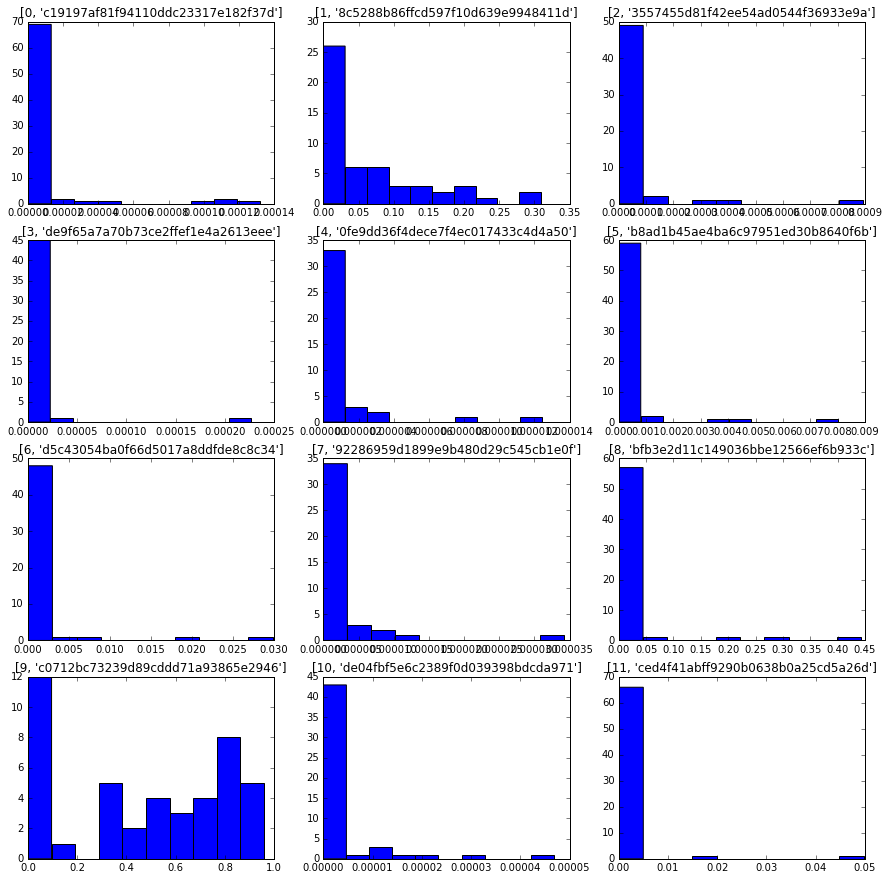

In [63]:
r,c=4,3
plt.figure(figsize=(15,15))
for k1 in range(r*c):
    #ind=np.random.randint(len(y_pred))
    ind=k1
    plt.subplot(r,c,k1+1)
    plt.hist(y_pred[ind])
    p_id=df_train.id[val_nc[ind]]
    plt.title([ind,p_id])
    #plt.show()


wait ...
processing: 0, 0015ceb851d7251b8f399e39779d1e7d
[44 42 31]
(64, 3, 512, 512)


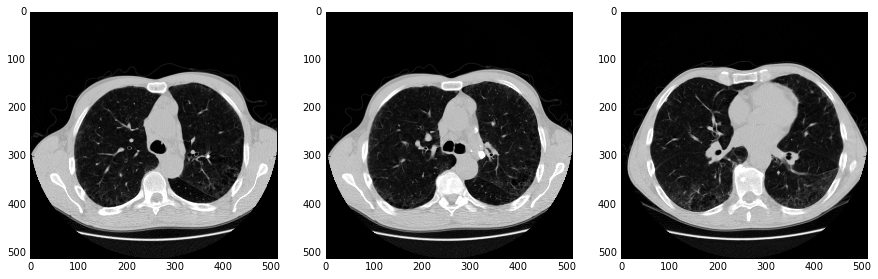

processing: 3, 006b96310a37b36cccb2ab48d10b49a3
[51 47 52]
(57, 3, 512, 512)


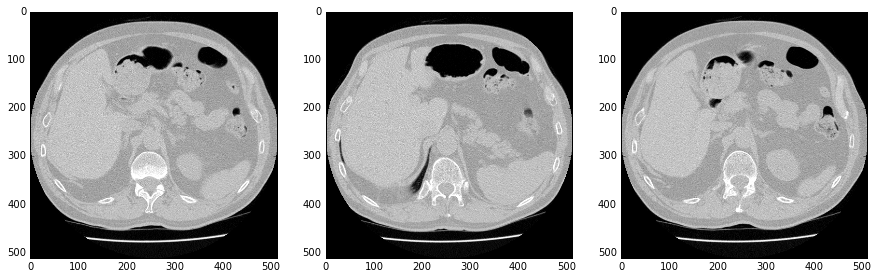

processing: 4, 008464bb8521d09a42985dd8add3d0d2
[46 24 43]
(48, 3, 512, 512)


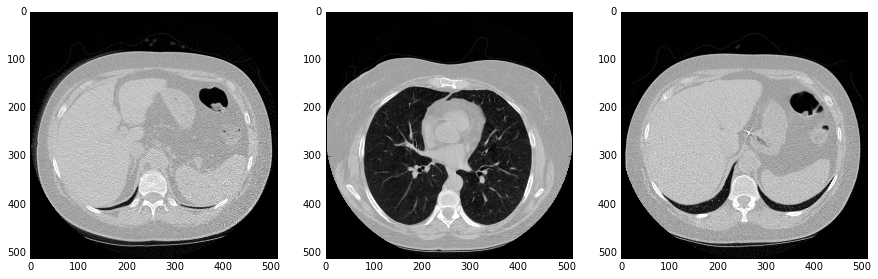

processing: 8, 00edff4f51a893d80dae2d42a7f45ad1
[28 16 33]
(44, 3, 512, 512)


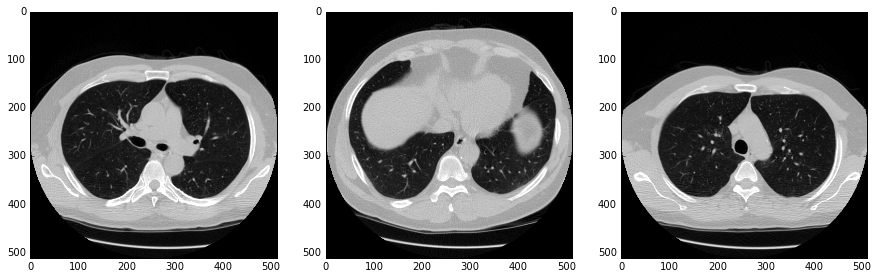

processing: 15, 0257df465d9e4150adef13303433ff1e
[47 58 59]
(61, 3, 512, 512)


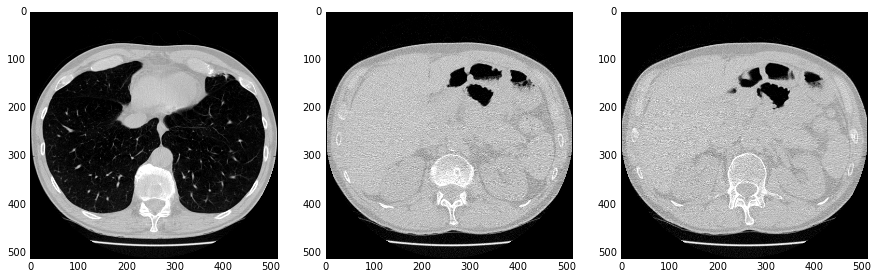

processing: 18, 02801e3bbcc6966cb115a962012c35df
[65 46 45]
(68, 3, 512, 512)


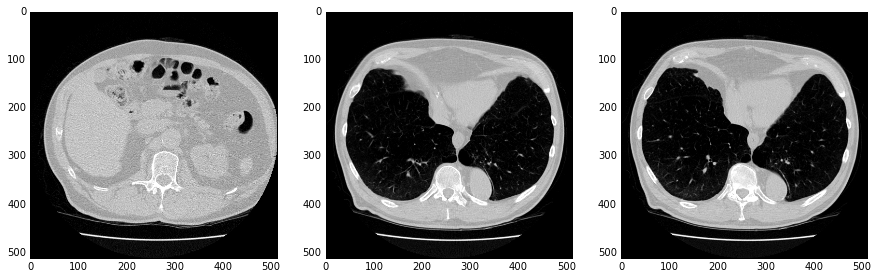

processing: 19, 028996723faa7840bb57f57e28275e4c
[58 56 55]
(60, 3, 512, 512)


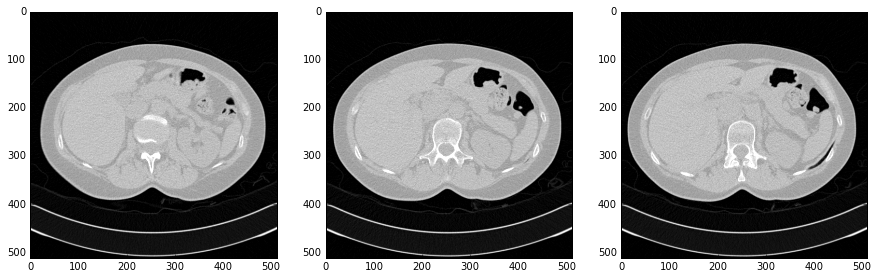

processing: 27, 04a8c47583142181728056310759dea1
[34 33 30]
(50, 3, 512, 512)


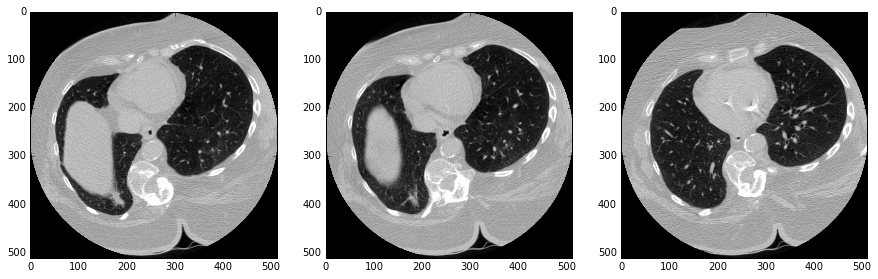

processing: 31, 05609fdb8fa0895ac8a9be373144dac7
[50 48 49]
(51, 3, 512, 512)


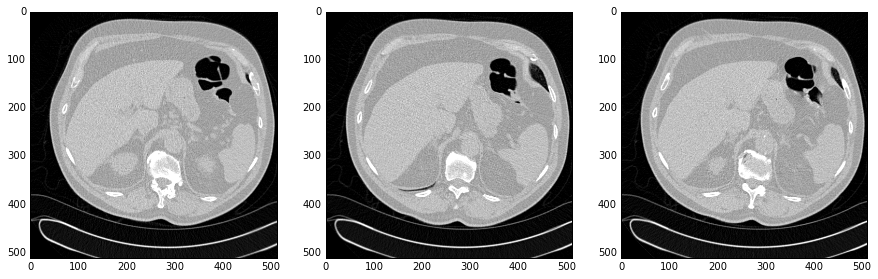

processing: 32, 059d8c14b2256a2ba4e38ac511700203
[28 27 39]
(43, 3, 512, 512)


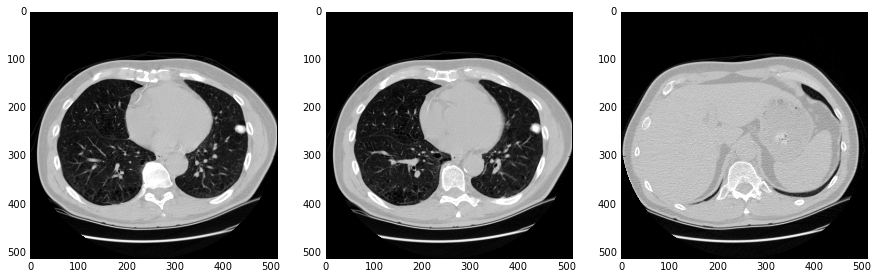

processing: 34, 064366faa1a83fdcb18b2538f1717290
[35 20 42]
(44, 3, 512, 512)


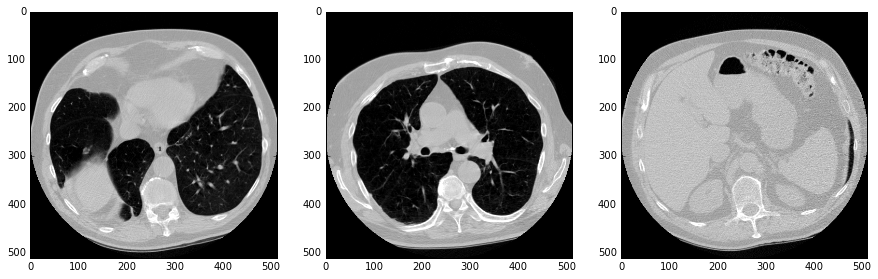

processing: 37, 0708c00f6117ed977bbe1b462b56848c
[28 38 45]
(58, 3, 512, 512)


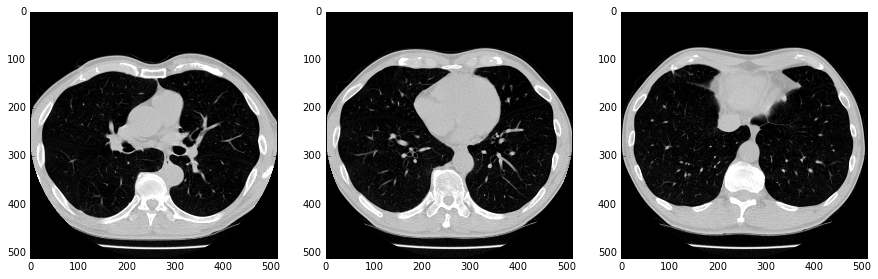

processing: 38, 07349deeea878c723317a1ce42cc7e58
[21 55 50]
(56, 3, 512, 512)


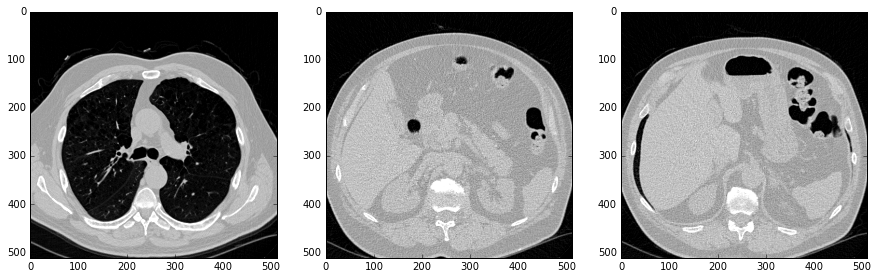

processing: 40, 07bca4290a2530091ce1d5f200d9d526
[42 16  4]
(43, 3, 512, 512)


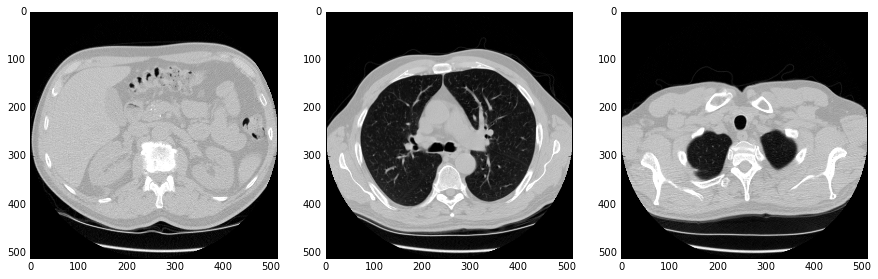

processing: 43, 081f4a90f24ac33c14b61b97969b7f81
[50 51 52]
(107, 3, 512, 512)


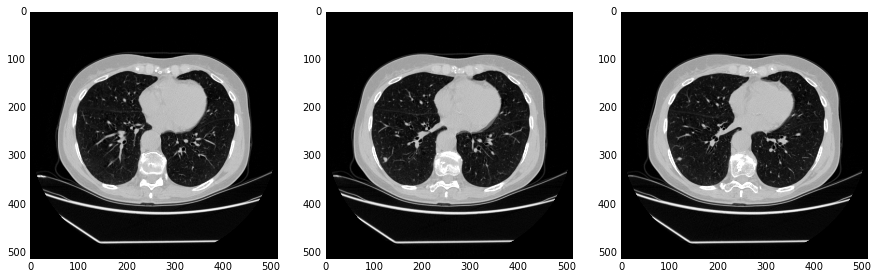

processing: 53, 09d7c4a3e1076dcfcae2b0a563a28364
[ 6  0 54]
(59, 3, 512, 512)


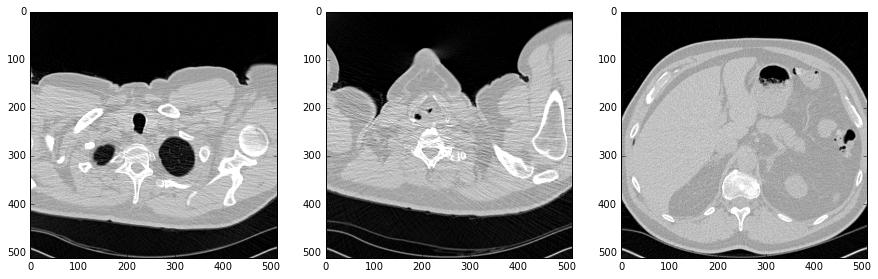

processing: 59, 0acbebb8d463b4b9ca88cf38431aac69
[50 37 66]
(67, 3, 512, 512)


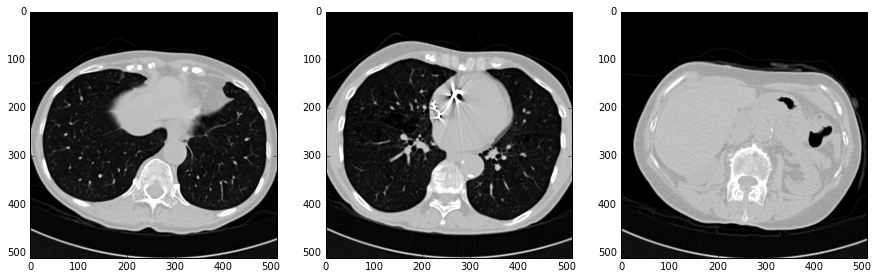

processing: 61, 0c0de3749d4fe175b7a5098b060982a1
[19 27 35]
(40, 3, 512, 512)


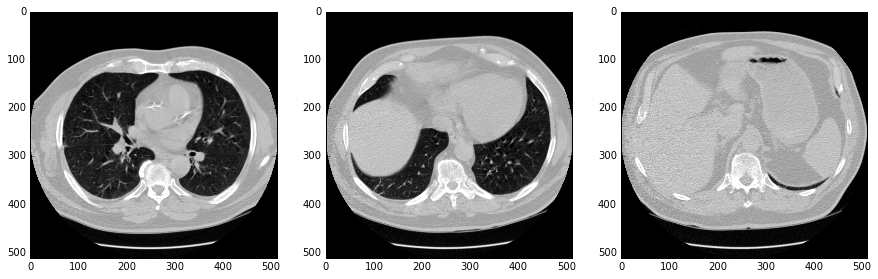

processing: 62, 0c37613214faddf8701ca41e6d43f56e
[43 46 45]
(54, 3, 512, 512)


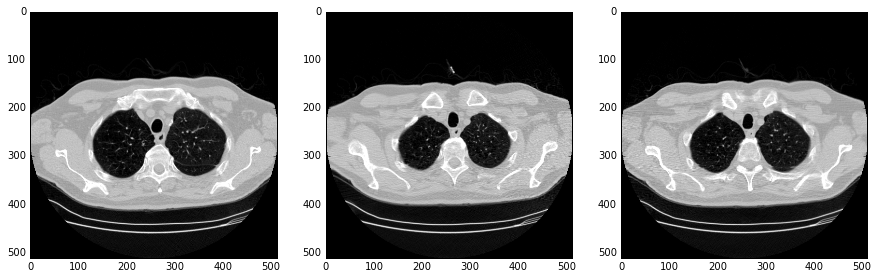

processing: 64, 0c60f4b87afcb3e2dfa65abbbf3ef2f9
[ 5 26  1]
(45, 3, 512, 512)


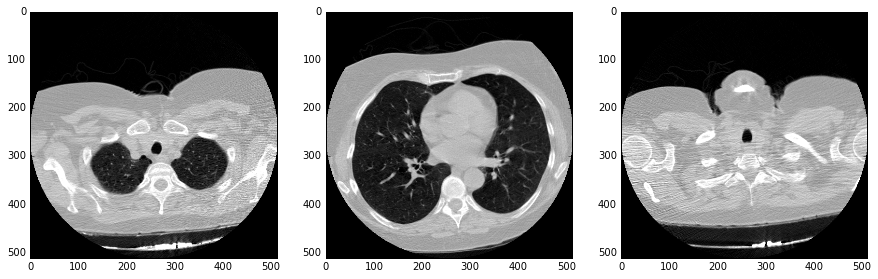

In [65]:
# cancer data

print 'wait ...'
# load data
y_pred_cancer=[]
for p in cancer[:20]:
    p_id=df_train.id[p]
    print 'processing: %s, %s' %(p,p_id)
    f4=h5py.File(path2dsb,'r')
    X0=f4[p_id]

    X3=[]
    step=3
    for k in range(0,X0.shape[0]-3,step):
        tmp=X0[k:k+3]
        tmp=tmp[np.newaxis,:]
        X3.append(tmp)
    X3=np.vstack(X3)        
    y_p=model.predict(preprocess(X3,param_prep))
    y_pred_cancer.append(y_p[:,0])   

    # top n values 
    X3=preprocess(X3,param_prep)
    n=3
    yk=np.array(y_p[:,0])
    idx = (-yk).argsort()[:n]
    print idx
    print X3.shape
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(X3[idx[0],0],cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(X3[idx[1],0],cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(X3[idx[2],0],cmap='gray')
    plt.show()
    
# close file
f4.close()

# average, max and avg of top max
yp_cancer_avg=[]
yp_cancer_max=[]
yp_cancer_avgtop=[]
for k in range(len(y_pred_cancer)):
    maxyp=np.max(y_pred_cancer[k])
    yp_cancer_avg.append(np.mean(y_pred_cancer[k]))
    yp_cancer_max.append(np.max(y_pred_cancer[k]))
    n=4
    yk=np.array(y_pred_cancer[k])
    idx = (-yk).argsort()[:n]
    #print np.sort(idx)
    yp_cancer_avgtop.append(np.mean(yk[idx]))


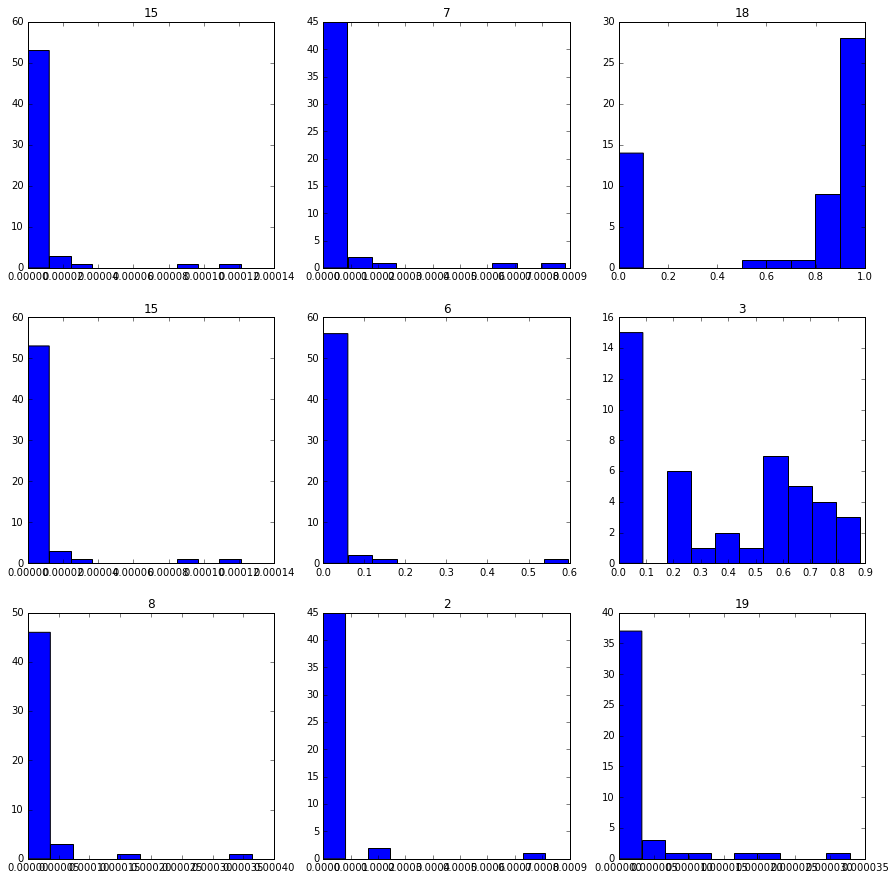

In [43]:
# plts
r,c=3,3
plt.figure(figsize=(15,15))
for k1 in range(r*c):
    ind=np.random.randint(len(y_pred_cancer))
    plt.subplot(r,c,k1+1)
    #plt.stem(y_pred_cancer[ind])
    plt.hist(y_pred_cancer[ind])
    plt.title(ind)
    #plt.show()
